# Finetuning with Trainer and text-classification model validation

In [1]:
# Current data source: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp/data
# Original notebook created by http://bkonat[dot]home[dot]amu[dot]edu[dot]pl

In [2]:
# !pip install transformers[torch]
# !pip install accelerate -U
#ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`: Please run `pip install transformers[torch]` or `pip install accelerate -U

In [3]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import seaborn as sn
import torch

from datasets import load_dataset, Dataset, DatasetDict
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from torchinfo import summary
from transformers import AutoModelForSequenceClassification, AutoConfig, Trainer, TrainingArguments, DataCollatorWithPadding, AutoTokenizer, pipeline

# Load data via datasets package and prepare _label to int_ dict 

In [4]:
root_dir = "data/kaggle_archive"
convert_to_csv = True

files = {'train': os.path.join(root_dir,'train.txt'),
         'test': os.path.join(root_dir,'test.txt'),
         'validate': os.path.join(root_dir,'val.txt')
         }

## Get target map 
#Section assumes that file contains all unique labels
ds_dict = {}
for k,v in files.items():
    ds_dict[k] = pd.read_csv(v, sep=';', header=None, names=['sentence', 'label'])
    
target_map = {k:i for i,k in enumerate(ds_dict['train']['label'].unique())}
reversed_target_map = {v:k for k, v in target_map.items()}
print(target_map)

for k,v in ds_dict.items():
    v['label'] = v['label'].map(target_map)
    
ds = DatasetDict({k: Dataset.from_pandas(v) for k,v in ds_dict.items()})
ds

{'sadness': 0, 'anger': 1, 'love': 2, 'surprise': 3, 'fear': 4, 'joy': 5}


DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2000
    })
    validate: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2000
    })
})

## Finetuning

### Configuring model and tokenizer

In [5]:
# model name or path to model
# model_path = 'SamLowe/roberta-base-go_emotions'
model_path = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_path)
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True)

tokenized_datasets = ds.map(tokenize_fn, batched=True)
tokenized_datasets

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    validate: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [6]:
config = AutoConfig.from_pretrained(model_path)

config.id2label = reversed_target_map
config.label2id = target_map

config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "sadness",
    "1": "anger",
    "2": "love",
    "3": "surprise",
    "4": "fear",
    "5": "joy"
  },
  "initializer_range": 0.02,
  "label2id": {
    "anger": 1,
    "fear": 4,
    "joy": 5,
    "love": 2,
    "sadness": 0,
    "surprise": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.38.2",
  "vocab_size": 30522
}

In [7]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_path, config=config, ignore_mismatched_sizes=True)

#If we get info Model's device: cpu - need to move model to gpu
#Check if your model runs on gpu (this should happen automatically, when gpu is available)
device = next(model.parameters()).device
print("Model's device:", device)

if torch.cuda.is_available():
    model = model.cuda()
    print("Running on GPU")
else:
    print("CUDA (GPU support) is not available. Model will run on CPU.")

summary(model)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model's device: cpu
Running on GPU


Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           4,614
├─Dropout: 1-4                                          --
Total params: 66,958,086
Trainable params: 66,958,086
Non-trainable params: 0

### Training

In [8]:
trained_model_path = f'output/models/{model_path}_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")}'

training_args = TrainingArguments(
  output_dir=f'{trained_model_path}/checkpoints',
  evaluation_strategy='epoch',
  logging_strategy='epoch',
  save_strategy='epoch',
  num_train_epochs=10,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=64,
)

# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.385900,0.201306,0.923500,0.886204
2,0.152100,0.176437,0.932000,0.885834
3,0.113000,0.225651,0.921500,0.876755
4,0.093800,0.220557,0.928500,0.884815
5,0.060300,0.295039,0.928500,0.888631
6,0.032500,0.389273,0.925000,0.877094
7,0.024100,0.370435,0.931000,0.894106
8,0.015100,0.426326,0.929000,0.887043
9,0.010500,0.419796,0.933500,0.896434
10,0.006500,0.440700,0.928500,0.885637


TrainOutput(global_step=10000, training_loss=0.08937461504936219, metrics={'train_runtime': 344.0927, 'train_samples_per_second': 464.991, 'train_steps_per_second': 29.062, 'total_flos': 1945612950228864.0, 'train_loss': 0.08937461504936219, 'epoch': 10.0})

### Classification

In [9]:
# Get last epoch number
checkpoint_no = [int(i.rsplit('-')[-1]) for i in os.listdir(f'{trained_model_path}/checkpoints')]
checkpoint_no.sort(reverse=True)
checkpoint_no

[10000, 9000, 8000, 7000, 6000, 5000, 4000, 3000, 2000, 1000]

In [10]:
#Inspect above results to decide which checkpoint to use, by default last is taken
chosen_checkpoint = checkpoint_no[0]
checkpoint_path = f'{trained_model_path}/checkpoints/checkpoint-{chosen_checkpoint}'

task = 'text-classification'

classifier = pipeline(task,
                      model=checkpoint_path,
                      device=0)

classifier.save_pretrained(f'{trained_model_path}/pipeline')


In [11]:
pred_val = classifier(ds['validate']['sentence'])
pred_val

[{'label': 'sadness', 'score': 0.9999853372573853},
 {'label': 'sadness', 'score': 0.9999856948852539},
 {'label': 'joy', 'score': 0.9989473223686218},
 {'label': 'anger', 'score': 0.9999752044677734},
 {'label': 'joy', 'score': 0.9999861717224121},
 {'label': 'joy', 'score': 0.9999860525131226},
 {'label': 'joy', 'score': 0.999985933303833},
 {'label': 'joy', 'score': 0.9999856948852539},
 {'label': 'joy', 'score': 0.9999866485595703},
 {'label': 'sadness', 'score': 0.999985933303833},
 {'label': 'anger', 'score': 0.9999772310256958},
 {'label': 'joy', 'score': 0.9999861717224121},
 {'label': 'sadness', 'score': 0.9999858140945435},
 {'label': 'sadness', 'score': 0.9999842643737793},
 {'label': 'sadness', 'score': 0.9999823570251465},
 {'label': 'joy', 'score': 0.9999860525131226},
 {'label': 'sadness', 'score': 0.9999817609786987},
 {'label': 'sadness', 'score': 0.9914841055870056},
 {'label': 'love', 'score': 0.999937891960144},
 {'label': 'joy', 'score': 0.9999850988388062},
 {'lab

In [12]:
validated_df = ds_dict['validate'].copy(deep=True)
validated_df['predicted'] = [i['label'] for i in pred_val]
validated_df['label'] = validated_df['label'].map(reversed_target_map)
validated_df.to_csv(f'{trained_model_path}/validated.csv', index=False)

acc: 0.9375
f1: 0.911665087883641


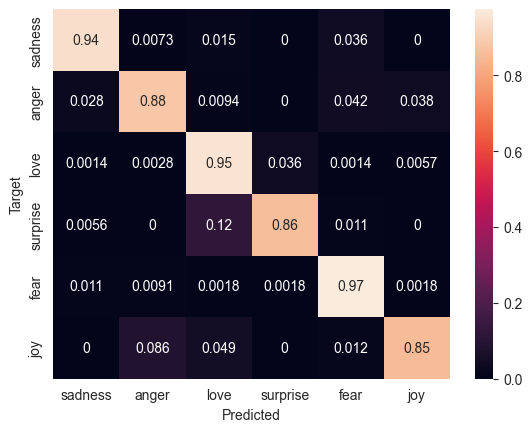

In [13]:
print("acc:", accuracy_score(validated_df['label'], validated_df['predicted']))
print("f1:", f1_score(validated_df['label'], validated_df['predicted'], average='macro'))

def plot_cm(cm):
    classes = list(target_map.keys())
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='.2g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

cm = confusion_matrix(validated_df['label'], validated_df['predicted'], normalize='true')
plot_cm(cm)